# pH-rate Data

This workbook contains the code and imports the data to explore the pH rate profiles in the paper.

The data being plotted is from "On the Rearrangement in Dioxane/Water of (*Z*)-Arylhydrazones of 5-Amino-3-benzoyl-1,2,4-oxadiazole into (2-Aryl-5-phenyl-2*H*-1,2,3-triazol-4-yl)ureas: Substituent Effects on the Different Reaction Pathways." F. D'Anna, V. Frenna, G. Macaluso, S. Marullo, S. Morganti, V. Pace, D. Spinelli, R. Spisani, C. Tavani, *J. Org. Chem.*, **2006**, *71*, 5616-5624. https://doi.org/10.1021/jo0605849

The data is found in tables within the supplementary material at https://ndownloader.figstatic.com/files/4775281


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [1]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.constants as constants  # a collection of scientific constants
from scipy.optimize import curve_fit

!pip install uncertainties

import uncertainties as un
from uncertainties import unumpy as unp

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
github_location = "./data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

#################################################################
### a function calculate rsq for data and a model with parameters
#################################################################

def rsq(x, y, popt, model):
    ### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    y_calc = model(x, *popt)
    residuals = y-y_calc
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)   # calculate correlation constant rsq
    return(r_squared)


## Read in Data

The data is read in. The columns are multiplied by $10^4$ or $10^5$ depending on the information in the column header. Each data file will have one or othe other scale. 

After running this code we will have a dataframe with pH as the index and a correct value for $\log{k_{obs}}$

In [4]:
############################################
### Read in data from literature example 
############################################

datafile = "1c-data.csv"   # Change this file name as you swith data sets

df = pd.read_csv(github_location + datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pS+", 
                 comment = "#") 


#########################################################
### Determine scale from column header name           
#########################################################

if df.columns[0] == "k(A,R)x10^5":
    name = "k(A,R)x10^5"
    colname = df.columns[0]
    factor = 10**-5
elif df.columns[0] == "k(A,R)x10^4":
    name = "k(A,R)x10^4"
    colname = df.columns[0]
    factor = 10**-4
else:
    name = "ERROR"           # This will still crash everything in the next part of the program but at least you will know why.
    colname = df.columns[0]
    factor = 0


###############################
### Calculations            
###############################

df["log_k"] = np.log10(df[name] * factor)   # if 'name' does not match a column header in 'df' there will be an error

display(df.head())

,"k(A,R)x10^4",BUFFER,log_k
pS+,,,
0.10,14.30,HCl,-2.844664
0.30,12.10,HCl,-2.917215
0.53,9.14,HCl,-3.039054
0.72,7.10,HCl,-3.148742
0.97,4.54,HCl,-3.342944


## Plot and Curve Fits

The code below will extract the x,y data for our plots and make the plot.  There is also code to fit the data according to the three rate constants of the reaction and acidity.

Ka = 0.47+/-0.08 
kOH = 2.18+/-0.06 
kH2O = (1.24+/-0.04)E-05 
kH = 0.00233+/-0.00030 
pKa = 0.33+/-0.07
kH/Ka = 0.00499+/-0.00026


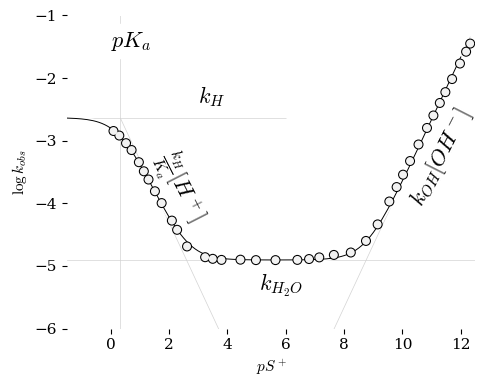

In [10]:
##############################################################
### Define a function that calculates the equation being
### used for the model that will be fit to the data.
##############################################################

def model(pH, Ka = 0.1, kOH=0.1, kH2O = 0.1, kH = 0.1):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = (kOH * (KW/H) + kH2O + kH * (H/Ka))*(Ka/(Ka + H))
    return(np.log10(k_obs))


#####################################################
### Get series of data to plot from the dataframe 
#####################################################

x = list(df.index)
y = list(df["log_k"])


##################################################
### Curve Fit                                
##################################################

if True:

    ### Set bounds so rate consatnts are never negative and constrain Ka value if needed
    min_Ka = 0.01
    max_Ka = 10       # One data set will want infinite Ka value because of no curvature in that region. Limit max value.
    k_min = 0
    k_max = np.inf

    lower_bounds = [min_Ka, k_min, k_min, k_min]    # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [max_Ka, k_max, k_max, k_max] # upper bounds for Ka but no upper bounds for kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    ### Perform the curve fit. Will return a list of parameters and an array of statistical info.
    parameters, pcov = curve_fit(model, x, y, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    param = un.correlated_values(parameters, pcov)

    [Ka, kOH, kH2O, kH] = param        ### Assign the parameter list to values
    


    ################################################################
    ### make a line from the parameters and the model            
    ### this would be the line of the curve fit when plotted     
    ################################################################

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 12 + step, step)     # make an array of points to calculate y-values from
    fity = model(x1, *parameters)     # Calculate those y-values using the model


##################################################
### Setup a figure and choose a stylesheet     
##################################################

style_file = "tufte.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)       # add 7% empty space around outside of plot area   

############################
### Set labels and scale 
############################

ax.set(
#    title="pH rate profilr",       
          ylabel=r"$\log{k_{obs}}$", 
          xlabel=r"$pS^+$",                
          xlim=[-1.5,12.5],                  
          ylim=[-6,-1]
         )

#########################################
### Plot the data                     
#########################################


#plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)

ax.scatter(x,y, s=52, color="black",  edgecolors = "none", zorder=2)
ax.scatter(x,y, s=32, color="white",  edgecolors = "none", alpha = 1, zorder=2)
ax.scatter(x,y, s=32, color="gray",  edgecolors = "none", alpha = 0.1, zorder=2)

if True:    ### True for decorations (component lines and labels)
    plt.vlines(-np.log10(Ka.n), -6,-1, colors = "lightgray", linewidth = 0.5, zorder=0)
    plt.hlines(np.log10(kH.n), -2,6, colors = "lightgray", linewidth = 0.5, zorder=0)
    
    H_x = 10**-np.linspace(10**-Ka.n, 12.5, 50)
    kHline_y = kH.n/Ka.n * H_x
    ax.plot(-np.log10(H_x), np.log10(kHline_y), color='lightgray', zorder=0, linewidth=0.5)
    
    H_x = 10**-np.linspace(-1.5, 12.5, 50)
    kHline_y = (H_x/H_x)*kH2O.n   # using (pH_x/pH_x) creates an array of unitary values 
    ax.plot(-np.log10(H_x), np.log10(kHline_y), color='lightgray', zorder=0, linewidth=0.5)
    
    H_x = 10**-np.linspace(-1.5, np.max(x), 50)
    kHline_y = kOH.n * 10**(-14) / H_x
    ax.plot(-np.log10(H_x), np.log10(kHline_y), color='lightgray', zorder=0, linewidth=0.5)

    plt.text(3, -2.4, "$k_{H}$", fontsize=16, rotation=(0), backgroundcolor="white") 
    plt.text(0, -1.5, "$pK_a$", fontsize=16, rotation=(0), backgroundcolor="white") 
    plt.text(1.2, -4.2, "$\\frac{k_{H}}{K_a}[H^+]$", fontsize=16, rotation=(-63), backgroundcolor="none") # 
    plt.text(5.1, -5.4, "$k_{H_2O}$", fontsize=16, rotation=(0)) 
    plt.text(10.1, -4.0, "$k_{OH}[OH^-]$", fontsize=16, rotation=(63)) 



#########################################
### Plot the line fit.                
#########################################
if True:
    ax.plot(x1, fity, color='white', zorder=1, linewidth=3)
    ax.plot(x1, fity, color='black', zorder=1, linewidth=0.7)

    #######################################################
    ### Print out Parameters and standard deviations    
    #######################################################

    print(f"Ka = {Ka:0.2G} ")
    print(f"kOH = {kOH:0.3G} ")
    print(f"kH2O = {kH2O:0.3G} ")
    print(f"kH = {kH:0.3G} ")
    print(f"pKa = {-unp.log10(Ka):0.2f}")
    print(f"kH/Ka = {kH/Ka:0.3g}")


#############################
### Output the final plot 
#############################

fig.savefig("images/plot_pH.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots

